# get_patch_location_array_for_image_level(run_parameters)

In [1]:
import time
import os
import sys

from collections import OrderedDict
import argparse

import numpy as np
import pandas as pd
import yaml

from skimage.filters import threshold_otsu
from skimage.color import rgb2lab

from PIL import ImageDraw
from PIL import TiffImagePlugin as tip

import openslide

sys.path.insert(0, '../src/python')
from digipath_toolkit import *

data_dir = '../../DigiPath_MLTK_data/Aperio'
file_type_list=['.svs', '.tif', '.tiff']
fs_od = get_file_size_ordered_dict(data_dir, file_type_list)
list_number = 0
for k, v in fs_od.items():
    print('%3i %30s: %i'%(list_number, k,v))
    list_number += 1

  0         CMU-1-Small-Region.svs: 1938955
  1               JP2K-33003-1.svs: 63847265
  2           CMU-1-JP2K-33005.svs: 132565343
  3                      CMU-1.svs: 177552579
  4                      CMU-3.svs: 253815723
  5               JP2K-33003-2.svs: 289250433
  6                      CMU-2.svs: 390750635


In [2]:
#                         test data file for threshold_otsu
run_parameters = {}

# data_dir = '../data/images/' 
# image_file_name = 'CMU-1-Small-Region.svs'
data_dir = '../../DigiPath_MLTK_data/Aperio'
image_file_name = 'CMU-1.svs'
run_parameters['wsi_filename'] = os.path.join(data_dir, image_file_name)
print('Image File:\n', run_parameters['wsi_filename'])

run_parameters['thumbnail_divisor'] = 10
run_parameters['patch_select_method'] = 'threshold_otsu' # 'threshold_rgb2lab'
run_parameters['patch_height'] = 224
run_parameters['patch_width'] = 224
run_parameters['threshold'] = 0

"""
                output & time test:                CALL - - get_patch_location_array()
"""
t0 = time.time()
patch_location_array = get_patch_location_array(run_parameters)
tt = time.time() - t0

print('%i images found\t%0.3f s\n'%(len(patch_location_array), tt))

print('type(patch_location_array) =',type(patch_location_array), '\t', len(patch_location_array),'\n')
for d in patch_location_array:
    print(d)

Image File:
 ../../DigiPath_MLTK_data/Aperio/CMU-1.svs
1526 images found	9.105 s

type(patch_location_array) = <class 'list'> 	 1526 

(105, 3176)
(105, 5640)
(329, 2952)
(553, 1384)
(1225, 16168)
(1673, 15720)
(1897, 2056)
(1897, 3400)
(1897, 6984)
(2121, 9224)
(2121, 12808)
(2121, 13928)
(2121, 14152)
(2569, 712)
(2569, 4520)
(2569, 10792)
(2569, 13256)
(2569, 13704)
(2793, 3176)
(2793, 3848)
(2793, 9448)
(2793, 13256)
(2793, 13928)
(2793, 14152)
(2793, 15944)
(2793, 16168)
(3017, 13480)
(3017, 13704)
(3241, 13928)
(3241, 14152)
(3465, 13928)
(3465, 14152)
(3465, 14376)
(3465, 14600)
(3689, 1832)
(3689, 14152)
(3689, 14376)
(3913, 14376)
(4137, 14152)
(4137, 15048)
(4137, 15496)
(4137, 16168)
(4361, 14600)
(4361, 15048)
(4361, 15496)
(4585, 14824)
(4585, 15048)
(4585, 15272)
(4585, 15944)
(4809, 15272)
(5033, 2952)
(5257, 2952)
(5481, 16168)
(5705, 15720)
(5929, 10568)
(5929, 11464)
(6153, 40)
(6153, 264)
(6153, 2952)
(6377, 7208)
(6825, 1384)
(6825, 5416)
(7049, 5416)
(7049, 6088)
(

In [11]:
def get_patch_location_array_for_image_level(run_parameters):
    """ Usage: patch_location_array = get_patch_location_array_for_image_level(run_parameters)
        using 'patch_select_method", find all upper left corner locations of patches
        that won't exceed image size givin the 'patch_height' and 'patch_width'

    Args (run_parameters):  python dict.keys()
                                wsi_filename:           file name (with valid path)
                                patch_height:           patch size = (patch_width, patch_height)
                                patch_width:            patch size = (patch_width, patch_height)
                                thumbnail_divisor:      wsi_image full size divisor to create thumbnail image
                                patch_select_method:    'threshold_rgb2lab' or 'threshold_otsu'
    Returns:
        patch_location_array

    """
    patch_location_array = []

    wsi_filename = run_parameters['wsi_filename']
    thumbnail_divisor = run_parameters['thumbnail_divisor']
    patch_select_method = run_parameters['patch_select_method']
    patch_height = run_parameters['patch_height']
    patch_width = run_parameters['patch_width']
    image_level = run_parameters['image_level']
    threshold = run_parameters['threshold']

    #                     OpenSlide open                      #
    os_im_obj = openslide.OpenSlide(wsi_filename)
    
    level_count = os_im_obj.level_count
    level_downsamples = os_im_obj.level_downsamples
    obj_level_diminsions = os_im_obj.level_dimensions
    
    print('%i levels'%(level_count))
    for k in range(level_count):
        print(k, level_downsamples[k], obj_level_diminsions[k])
    
    pixels_height = obj_level_diminsions[image_level][1]
    rows_fence_array = get_fence_array(patch_length=patch_height, overall_length=pixels_height)

    pixels_width = obj_level_diminsions[image_level][0]
    cols_fence_array = get_fence_array(patch_length=patch_width, overall_length=pixels_width)

    thumbnail_size = (pixels_width // thumbnail_divisor, pixels_height // thumbnail_divisor)
    small_im = os_im_obj.get_thumbnail(thumbnail_size)
    os_im_obj.close()
    #                     OpenSlide close                     #
    print('sizes\trows_fence_array: %i\tcols_fence_array: %i'%(len(rows_fence_array),len(cols_fence_array)))
    print('small_im\th: %i\tw: %i\t'%(pixels_height, pixels_width), thumbnail_size, '\t', small_im.size)
    mask_im = get_sample_selection_mask(small_im, patch_select_method)
    print('type(mask_im)',type(mask_im))
    it_rows = zip(rows_fence_array[:, 0] // thumbnail_divisor,
                  rows_fence_array[:, 1] // thumbnail_divisor,
                  rows_fence_array[:, 0])

    lft_cols = cols_fence_array[:, 0] // thumbnail_divisor
    rgt_cols = cols_fence_array[:, 1] // thumbnail_divisor
    cols_array = cols_fence_array[:, 0]
    do_print = True
    for tmb_row_top, tmb_row_bot, row_n in it_rows:
        it_cols = zip(lft_cols, rgt_cols, cols_array)
        for tmb_col_lft, tmb_col_rgt, col_n in it_cols:
            if (mask_im[tmb_row_top:tmb_row_bot, tmb_col_lft:tmb_col_rgt]).sum() > threshold:
                patch_location_array.append((row_n, col_n))
                if do_print == True:
                    do_print = False
                    print('mask(%i:%i, %i:%i)'%(tmb_row_top,tmb_row_bot,tmb_col_lft,tmb_col_rgt))
    print('mask(%i:%i, %i:%i)'%(tmb_row_top,tmb_row_bot,tmb_col_lft,tmb_col_rgt))
    
    return patch_location_array

In [12]:
for im_lvl in range(3):
    run_parameters['image_level'] = im_lvl
    patch_location_array = get_patch_location_array_for_image_level(run_parameters)
    print(len(patch_location_array), '\n')

3 levels
0 1.0 (46000, 32914)
1 4.000121536217793 (11500, 8228)
2 16.00048614487117 (2875, 2057)
rows_fence_array: 146	cols_fence_array: 205
h: 32914	w: 46000	 (4600, 3291) 	 (4600, 3291)
type(mask_im) <class 'numpy.ndarray'>
mask(10:32, 317:339)
mask(3258:3280, 4573:4595)
1526 

3 levels
0 1.0 (46000, 32914)
1 4.000121536217793 (11500, 8228)
2 16.00048614487117 (2875, 2057)
rows_fence_array: 36	cols_fence_array: 51
h: 8228	w: 11500	 (1150, 822) 	 (1150, 822)
type(mask_im) <class 'numpy.ndarray'>
mask(8:30, 26:48)
mask(792:814, 1123:1146)
621 

3 levels
0 1.0 (46000, 32914)
1 4.000121536217793 (11500, 8228)
2 16.00048614487117 (2875, 2057)
rows_fence_array: 9	cols_fence_array: 12
h: 2057	w: 2875	 (287, 205) 	 (287, 205)
type(mask_im) <class 'numpy.ndarray'>
mask(2:24, 76:98)
mask(181:203, 255:278)
50 



In [17]:
def get_patch_locations_preview_imagefor_image_level(run_parameters):
    """ Usage: 
    mask_image, thumb_preview, patch_location_array = get_patch_locations_preview_imagefor_image_level(run_parameters)
    get the images and data needed to display where the patches are for the input parameters

    Args (run_parameters):  python dict.keys()
                                wsi_filename:           file name (with valid path)
                                border_color:           patch-box representation color 'red', 'blue' etc
                                patch_height:           patch size = (patch_width, patch_height)
                                patch_width:            patch size = (patch_width, patch_height)
                                thumbnail_divisor:      wsi_image full size divisor to create thumbnail image
                                patch_select_method:    'threshold_rgb2lab' or 'threshold_otsu'

    Returns:
        mask_image:             black & white image of the mask
        thumb_preview:          thumbnail image with patch locations marked
        patch_location_array:   list of patch locations used [(row, col), (row, col),... ]

    """
    wsi_filename = run_parameters['wsi_filename']
    patch_select_method = run_parameters['patch_select_method']
    thumbnail_divisor = run_parameters['thumbnail_divisor']
    patch_height = run_parameters['patch_height'] // thumbnail_divisor - 1
    patch_width = run_parameters['patch_width'] // thumbnail_divisor - 1
    border_color = run_parameters['border_color']
    image_level = run_parameters['image_level']
    threshold = run_parameters['threshold']

    #                     OpenSlide open                      #
    os_im_obj = openslide.OpenSlide(wsi_filename)
    
    level_count = os_im_obj.level_count
    level_downsamples = os_im_obj.level_downsamples
    obj_level_diminsions = os_im_obj.level_dimensions
    
    # print('%i levels'%(level_count))
    # for k in range(level_count):
    #     print(k, level_downsamples[k], obj_level_diminsions[k])

    # pixels_width = os_im_obj.dimensions[0]
    # pixels_height = os_im_obj.dimensions[1]
    pixels_width = obj_level_diminsions[0]
    
    thumbnail_size = (pixels_width // thumbnail_divisor, pixels_height // thumbnail_divisor)
    thumb_preview = os_im_obj.get_thumbnail(thumbnail_size)
    os_im_obj.close()

    mask_image = get_sample_selection_mask(thumb_preview, patch_select_method)
    mask_image = tip.Image.fromarray(np.uint8(mask_image * 255), 'L')

    thumb_draw = ImageDraw.Draw(thumb_preview)
    patch_location_array = get_patch_location_array_for_image_level(run_parameters)

    for r, c in patch_location_array[:]:
        ulc = (c // thumbnail_divisor, r // thumbnail_divisor)
        lrc = (ulc[0] + patch_width, ulc[1] + patch_height)
        thumb_draw.rectangle((ulc, lrc), outline=border_color, fill=None)

    return mask_image, thumb_preview, patch_location_array

In [21]:
run_parameters['image_level'] = 2

run_parameters['threshold'] = 0
run_parameters['border_color'] = 'blue'
mask_im, prev_im, patch_array = get_patch_locations_preview_imagefor_image_level(run_parameters)


3 levels
0 1.0 (46000, 32914)
1 4.000121536217793 (11500, 8228)
2 16.00048614487117 (2875, 2057)
3 levels
0 1.0 (46000, 32914)
1 4.000121536217793 (11500, 8228)
2 16.00048614487117 (2875, 2057)
rows_fence_array: 9	cols_fence_array: 12
h: 2057	w: 2875	 (287, 205) 	 (287, 205)
type(mask_im) <class 'numpy.ndarray'>
mask(2:24, 76:98)
mask(181:203, 255:278)


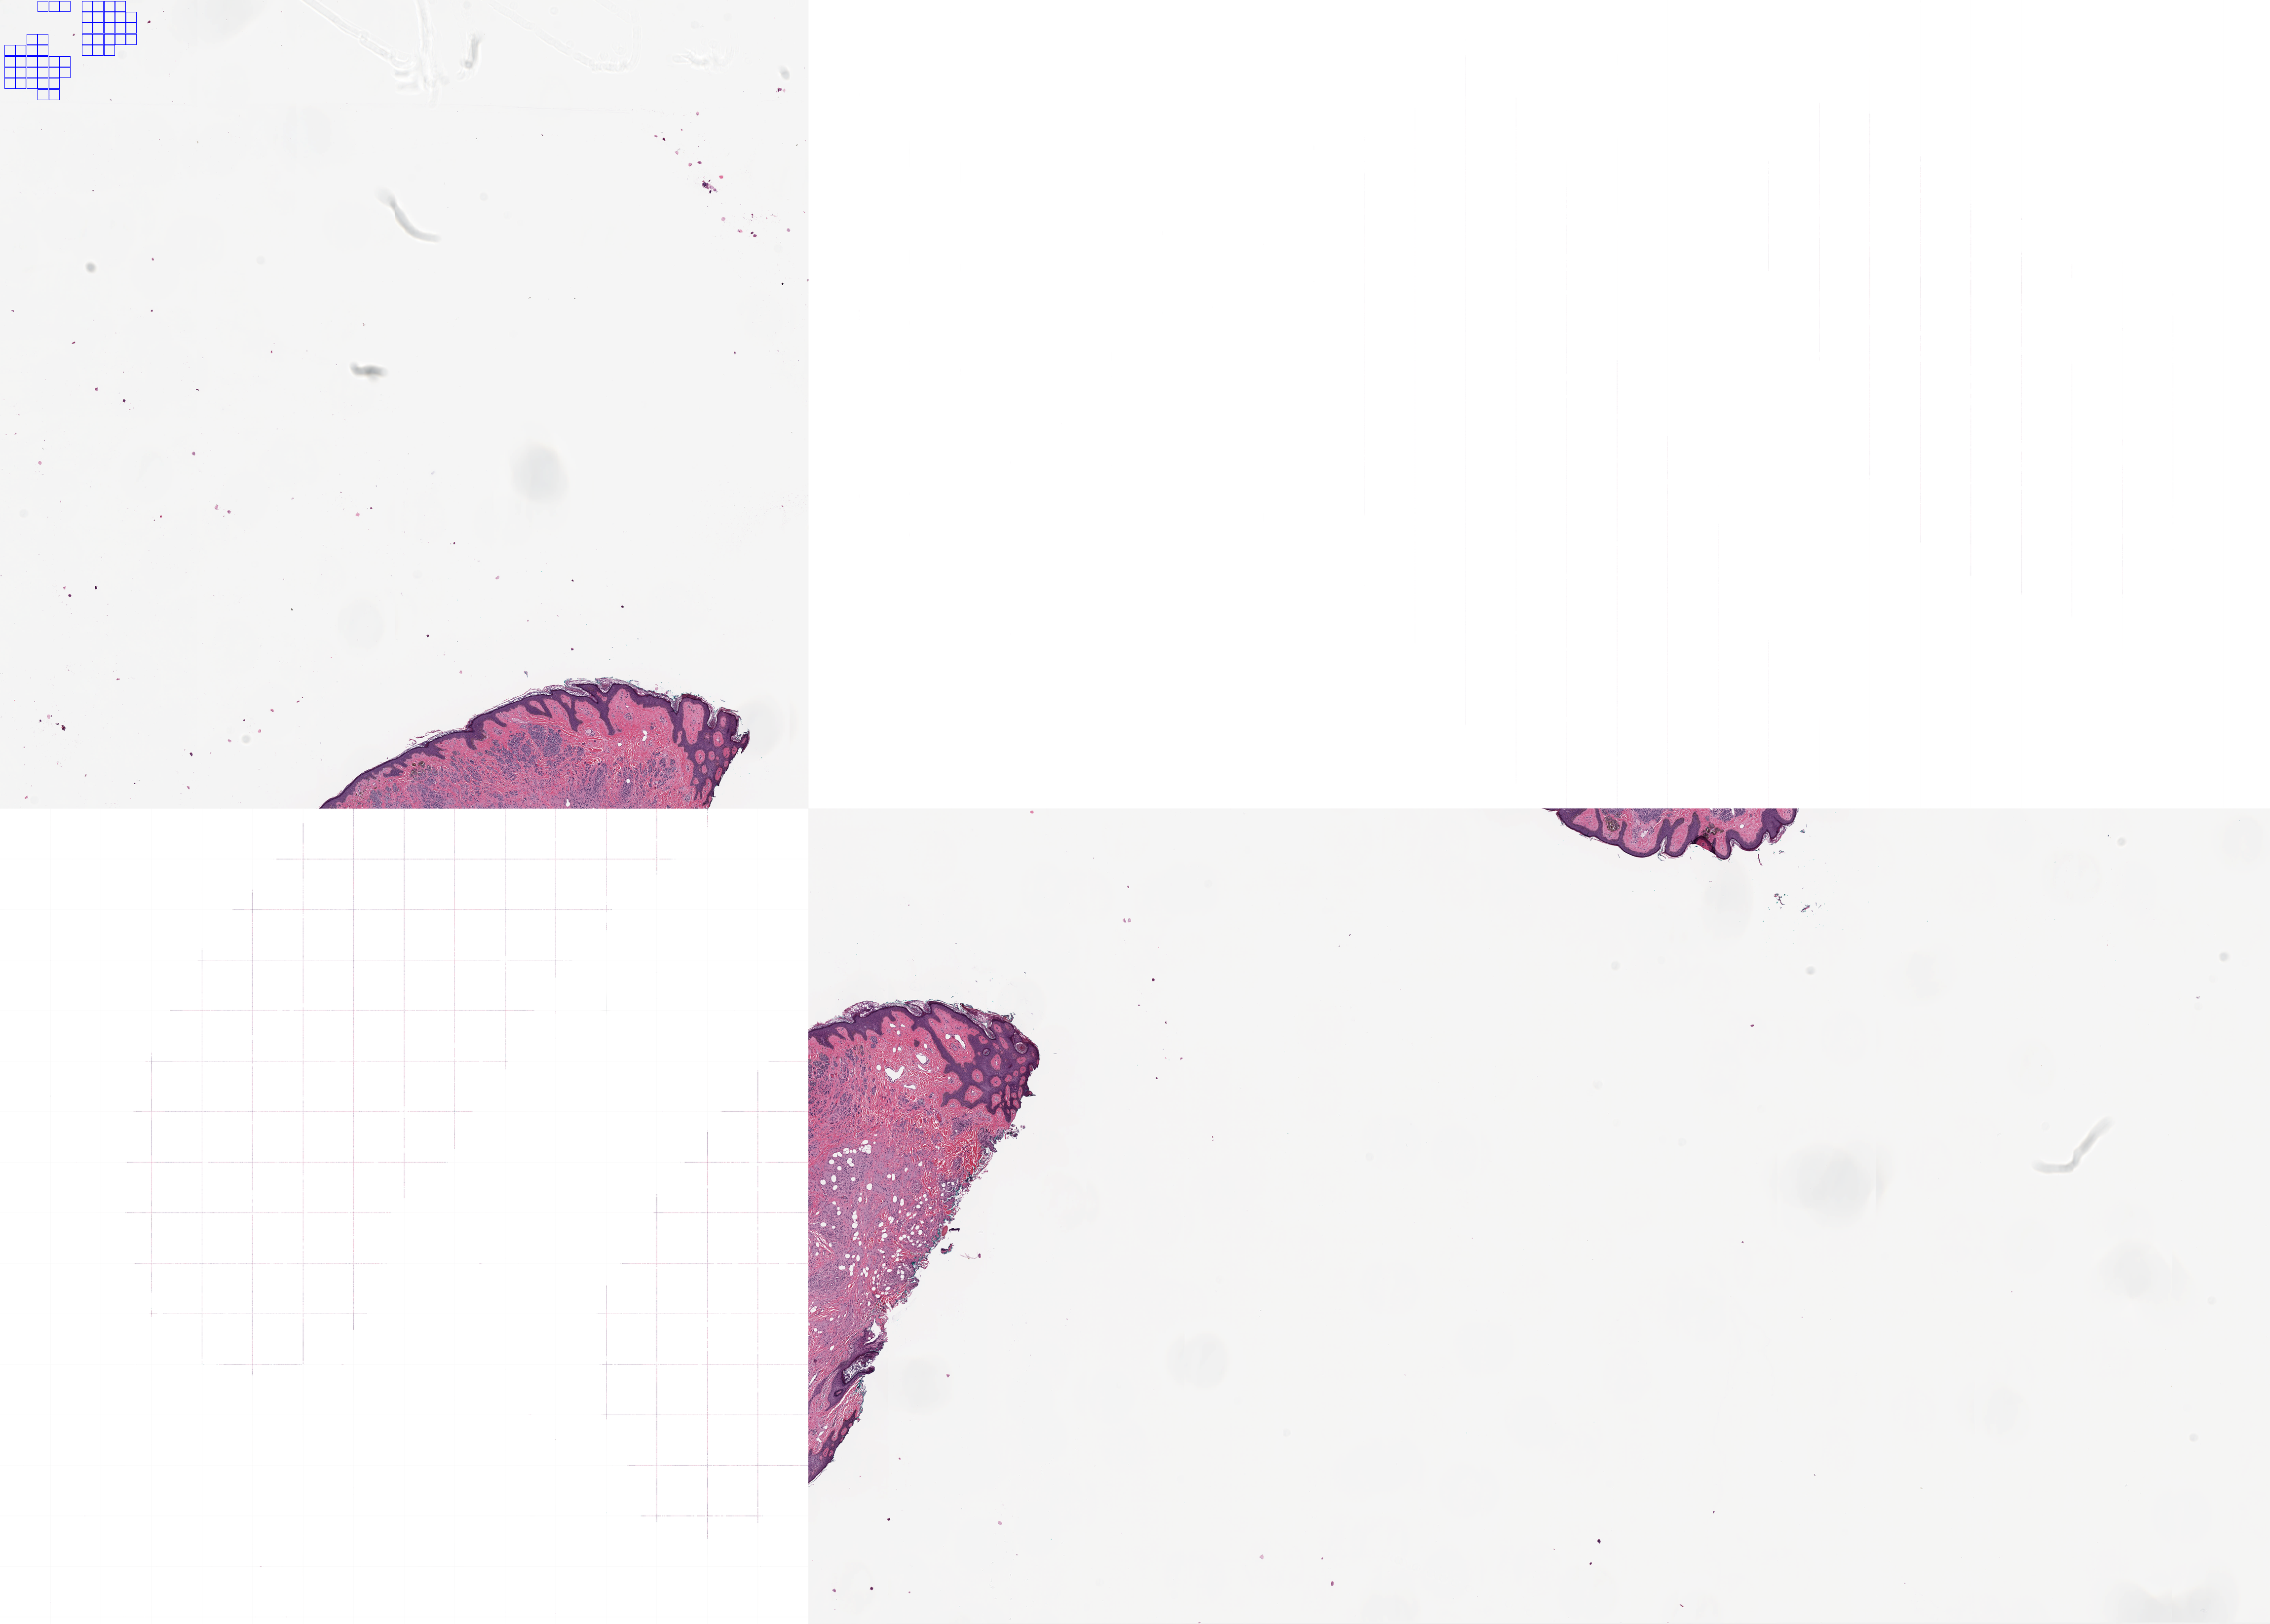

In [22]:
display(prev_im)